## 数据清理与特征工程

### 1. 处理movie_item

载入包文件

In [1100]:
import pandas as pd
import numpy as np
import json
import os
os.environ["KMP_DUPLICATE_LIB_OK"]  =  "TRUE"
# %load_ext scalene

载入数据

In [1101]:
# 载入电影数据
data_item = pd.read_json('../douban_movie/data/movie_item.json', lines=True)
print('电影数目：' ,data_item.shape[0])

data_item['movie_id'] = data_item['movie_id'].apply(lambda x: int(x[0][3:]))  # [电影-1300267] -> int(1300267)
data_item['comment_num'] = data_item['comment_num'].apply(lambda x: int(x[2:-1]))  # 全部 62309 条 -> int(62309)
data_item['question_num'] = data_item['question_num'].apply(lambda x: int(x[2:-1]))  # 全部23个 -> int(23)
data_item['rating_num'] = data_item['rating_num'].apply(lambda x: float(x[0]))   # [9.2] -> float(9.2)
data_item['rating_per_stars1'] = data_item['rating_per_stars1'].apply(lambda x: float(x[:-1]))   # 0.1% -> float(0.1)
data_item['rating_per_stars2'] = data_item['rating_per_stars2'].apply(lambda x: float(x[:-1]))  
data_item['rating_per_stars3'] = data_item['rating_per_stars3'].apply(lambda x: float(x[:-1]))  
data_item['rating_per_stars4'] = data_item['rating_per_stars4'].apply(lambda x: float(x[:-1]))  
data_item['rating_per_stars5'] = data_item['rating_per_stars5'].apply(lambda x: float(x[:-1]))
data_item['release_date'] = data_item['release_date'].apply(lambda x: int(x[0][1:-1]))  # [(1939)] -> int(1939)
data_item['vote_num'] = data_item['vote_num'].apply(lambda x: int(x[0]))   # [272357] -> int(272357)
data_item['movie_title'] = data_item['movie_title'].apply(lambda x: (x[0]))
# [238分钟] -> 238
data_item.loc[15,'runtime'] = ['80分钟']
pattern = '\d+'
import re
data_item['runtime'] = data_item['runtime'].apply(lambda x: (x[0]))
data_item['runtime'] = data_item['runtime'].str.findall(pattern,flags=re.IGNORECASE).apply(lambda x: int(x[0]))

def Intro(introduces):
    Intro_ = ''
    for intro in introduces:
        intro = intro.strip()
        Intro_ += intro
    return Intro_
data_item['intro'] = data_item.intro.apply(Intro)

电影数目： 246


In [1102]:
# 总评分最高的前10部电影
data_item.sort_values('rating_num', ascending=False)[['movie_title','rating_num']].head(10)

,movie_title,rating_num
243,肖申克的救赎 The Shawshank Redemption,9.6
236,控方证人 Witness for the Prosecution,9.6
102,美丽人生 La vita è bella,9.5
98,霸王别姬,9.5
107,十二怒汉 12 Angry Men,9.4
103,阿甘正传 Forrest Gump,9.4
101,这个杀手不太冷 Léon,9.4
100,辛德勒的名单 Schindler's List,9.4
108,机器人总动员 WALL·E,9.3
120,海豚湾 The Cove,9.3


In [1103]:
def column_expand(data, column, list_values):
    for cl in list_values:
        tt = data_item[column].apply(lambda x: str(x)).str.contains('\W'+cl+'\W')
        uu = data_item[column].apply(lambda x: str(x)).str.contains('^'+cl+'$')
        ee = data_item[column].apply(lambda x: str(x)).str.contains(cl+'\s')
        ff = data_item[column].apply(lambda x: str(x)).str.contains('\s'+cl)
#         print('cl', cl)
#         print('tt', tt)
#         print('uu', uu)
#         print('ee', ee)
        cl_ = tt | uu| ee | ff
        cl_ *= 1
#         print('c1_', cl_)
        data['%s_%s' %(column ,cl)] = cl_
#         print('data', data)
        
class_movie = ['剧情','爱情','喜剧','科幻','动作','悬疑','犯罪','恐怖','青春'
               ,'励志','战争','文艺','黑色幽默','传记','情色','暴力','音乐','家庭']
country_movie = ['大陆','美国','香港','台湾','日本','韩国','英国','法国','德国','意大利','西班牙','印度','泰国','俄罗斯'
 ,'伊朗','加拿大','澳大利亚','爱尔兰','瑞典','巴西','丹麦']

def get_values_list(data, column, sep=None):
    Language_values=[]
    def countLANG(Languages):
        for language in Languages:
            language = language.strip()
            if language in Language_values: 
                continue
            else:
                Language_values.append(language)
    if sep:
        pd.DataFrame(data[column].str.split(sep))[column].apply(countLANG);
    else:
        data[column].apply(countLANG);
    return Language_values

def Paiming(data, column, list_values):
    column_expand(data, column, list_values)
    df = pd.DataFrame( 
        {'数目':[data['%s_%s' %(column, p)].sum() for p in list_values]}
        , index=list_values).sort_values('数目', ascending=False)
    return df

In [1104]:
# 最受欢迎的电影导演排名
temp = Paiming(data_item, 'directedBy', get_values_list(data_item, 'directedBy'))
print('共有%s位导演入选TOP250电影榜:' %len(temp))
temp.head(10)

共有196位导演入选TOP250电影榜:


,数目
克里斯托弗·诺兰,7
宫崎骏,7
史蒂文·斯皮尔伯格,6
王家卫,5
李安,4
大卫·芬奇,3
刘镇伟,3
理查德·林克莱特,3
朱塞佩·托纳多雷,3
詹姆斯·卡梅隆,3


In [1105]:
# 最受欢迎的电影类别排名
movie_type_list = Paiming(data_item, 'genre', class_movie)
print(movie_type_list)

       数目
剧情    191
爱情     62
喜剧     49
犯罪     45
动作     32
悬疑     29
家庭     27
科幻     25
战争     17
传记     12
音乐      7
恐怖      2
情色      1
青春      0
文艺      0
黑色幽默    0
暴力      0
励志      0


In [1106]:
# 最受欢迎的演员排名
temp = Paiming(data_item, 'starring', get_values_list(data_item, 'starring'))
print('共有%s位演员入选TOP250电影榜:' %len(temp))
temp.head(11)

共有2317位演员入选TOP250电影榜:


,数目
张国荣,8
汤姆·汉克斯,7
布拉德·皮特,7
张曼玉,7
梁朝伟,7
伊桑·霍克,6
琼·艾伦,6
马特·达蒙,6
雨果·维文,6
莱昂纳多·迪卡普里奥,6


In [1107]:
# 最受欢迎的出品国家排名
temp = Paiming(data_item, 'country', country_movie)
print('共有%s个出品国家入选TOP250电影榜:' %len(temp))
temp.head(15)
temp

共有21个出品国家入选TOP250电影榜:


,数目
美国,141
英国,34
日本,29
法国,27
香港,26
德国,19
意大利,10
韩国,8
大陆,7
加拿大,7


In [1108]:
def geod_world(df, title, legend = False):
    """
    temp0 = temp.reset_index()
    df = pd.DataFrame({'NAME': temp0['index'].map(country_dict).tolist() 
                   ,'NUM': (np.log1p(temp0['数目'])*100).tolist()})
    """
    import geopandas as gp
    from matplotlib import pyplot as plt
    %matplotlib inline
    import matplotlib
    import seaborn as sns
    matplotlib.rc('figure', figsize = (14, 7))
    matplotlib.rc('font', size = 14)
    matplotlib.rc('axes', grid = False)
    matplotlib.rc('axes', facecolor = 'white')

    world_geod = gp.GeoDataFrame.from_file('./world_countries_shp/World_countries_shp.shp')
    data_geod = gp.GeoDataFrame(df)   # 转换格式
    da_merge = world_geod.merge(data_geod, on = 'NAME', how = 'left') # 合并
    sum(np.isnan(da_merge['NUM'])) # 
    da_merge['NUM'][np.isnan(da_merge['NUM'])] = 14.0#填充缺失数据
    da_merge.plot('NUM', k = 20, cmap = plt.cm.Blues,alpha= 1,legend = legend)
    plt.title(title, fontsize=15)#设置图形标题
    plt.gca().xaxis.set_major_locator(plt.NullLocator())#去掉x轴刻度
    plt.gca().yaxis.set_major_locator(plt.NullLocator())#去年y轴刻度

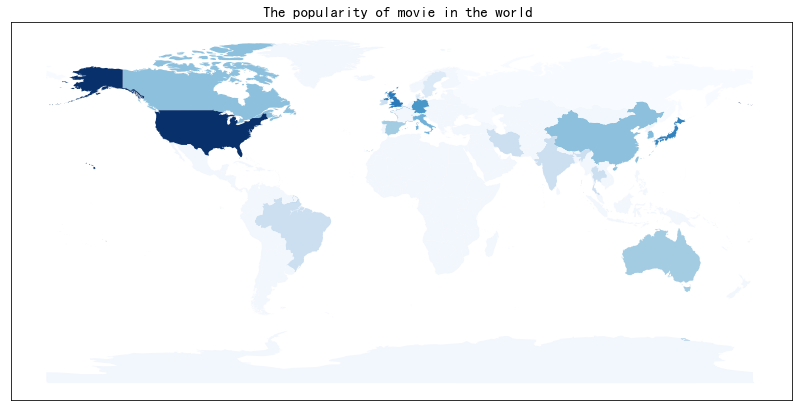

In [1109]:
country_dict = {'大陆':'China','美国':'United States','香港':'Hong Kong','台湾':'Taiwan, Province of China'
                 ,'日本':'Japan','韩国':'Korea, Republic of','英国':'United Kingdom','法国':'France','德国':'Germany'
                 ,'意大利':'Italy','西班牙':'Spain','印度':'India','泰国':'Thailand','俄罗斯':'Russian Federation'
                 ,'伊朗':'Iran','加拿大':'Canada','澳大利亚':'Australia','爱尔兰':'Ireland','瑞典':'Sweden'
                 ,'巴西':'Brazil','丹麦':'Denmark'}

temp0 = temp.reset_index()
df = pd.DataFrame({'NAME': temp0['index'].map(country_dict).tolist() 
                   ,'NUM': (np.log1p(temp0['数目'])*100).tolist()})
geod_world(df, 'The popularity of movie in the world ')

In [1110]:
# 最受欢迎的语言排名
temp = Paiming(data_item, 'language', get_values_list(data_item, 'language', sep='/'))
print('共有%s种语言入选TOP250电影榜:' %len(temp))
temp.head(15)

共有60种语言入选TOP250电影榜:


,数目
英语,170
法语,41
日语,37
汉语普通话,33
德语,25
粤语,24
意大利语,19
西班牙语,15
俄语,12
拉丁语,8


In [1111]:
# 电影时长的排名
data_item.sort_values('runtime', ascending=False)[['movie_title','runtime']].head(10)

,movie_title,runtime
0,乱世佳人 Gone with the Wind,238
221,牯岭街少年杀人事件 牯嶺街少年殺人事件,237
235,美国往事 Once Upon a Time in America,229
199,教父2 The Godfather: Part Ⅱ,202
110,指环王3：王者无敌 The Lord of the Rings: The Return of...,201
100,辛德勒的名单 Schindler's List,195
104,泰坦尼克号 Titanic,194
230,绿里奇迹 The Green Mile,189
11,与狼共舞 Dances with Wolves,181
210,指环王2：双塔奇兵 The Lord of the Rings: The Two Towers,179


In [1112]:
# 电影投票数的排名
data_item.sort_values('vote_num', ascending=False)[['movie_title','vote_num']].head(10)

,movie_title,vote_num
243,肖申克的救赎 The Shawshank Redemption,877684
101,这个杀手不太冷 Léon,838853
105,盗梦空间 Inception,766735
103,阿甘正传 Forrest Gump,714946
28,三傻大闹宝莱坞 3 Idiots,676928
106,千与千寻 千と千尋の神隠し,666166
104,泰坦尼克号 Titanic,657294
98,霸王别姬,631204
171,让子弹飞,612443
26,海上钢琴师 La leggenda del pianista sull'oceano,601595


In [1113]:
# 电影评价数的排名
data_item.sort_values('comment_num', ascending=False)[['movie_title','comment_num']].head(10)

,movie_title,comment_num
243,肖申克的救赎 The Shawshank Redemption,206334
105,盗梦空间 Inception,201260
113,少年派的奇幻漂流 Life of Pi,197790
28,三傻大闹宝莱坞 3 Idiots,192686
101,这个杀手不太冷 Léon,192324
83,疯狂动物城 Zootopia,182765
109,怦然心动 Flipped,178532
111,星际穿越 Interstellar,176341
98,霸王别姬,167573
171,让子弹飞,155386


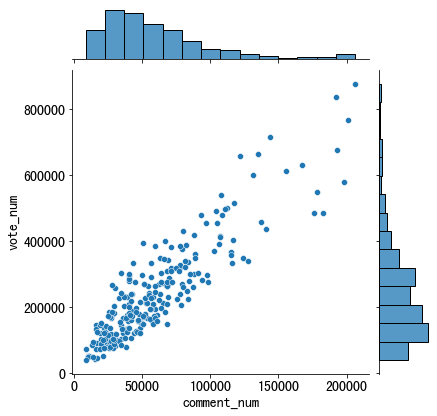

In [1114]:
import seaborn as sns
sns.jointplot(x="comment_num", y="vote_num", data=data_item)

In [1115]:
# 电影问题数的排名
data_item.sort_values('question_num', ascending=False)[['movie_title','question_num']].head(10)

,movie_title,question_num
111,星际穿越 Interstellar,1215
196,消失的爱人 Gone Girl,282
83,疯狂动物城 Zootopia,264
19,彗星来的那一夜 Coherence,200
161,心迷宫,184
163,超能陆战队 Big Hero 6,142
172,布达佩斯大饭店 The Grand Budapest Hotel,135
224,爆裂鼓手 Whiplash,133
223,恐怖游轮 Triangle,119
231,再次出发之纽约遇见你 Begin Again,116


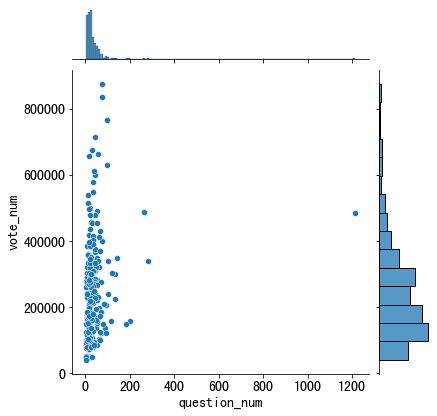

In [1116]:
sns.jointplot(x="question_num", y="vote_num", data=data_item)

In [1117]:
# 根据电影发布时间的规律
def plot2y(x_data, x_label, type1, y1_data, y1_color, y1_label, type2, y2_data, y2_color, y2_label, title):
    _, ax1 = plt.subplots()
    
    if type1 == 'hist':
        ax1.hist(x_data, histtype='stepfilled', bins=200, color = y1_color)
        ax1.set_ylabel(y1_label, color = y1_color) 
        ax1.set_xlabel(x_label)
        ax1.set_yscale('symlog')
        ax1.set_title(title)

    elif type1 == 'plot':
        ax1.plot(x_data, y1_data, color = y1_color)
        ax1.set_ylabel(y1_label, color = y1_color) 
        ax1.set_xlabel(x_label)
        ax1.set_yscale('linear')
        ax1.set_title(title)
        
    elif type1 == 'scatter':
        ax1.scatter(x_data, y1_data, color = y1_color, s = 10, alpha = 0.75)
        ax1.set_ylabel(y1_label, color = y1_color) 
        ax1.set_xlabel(x_label)
        ax1.set_yscale('symlog')
        ax1.set_title(title)
        
    if type2 == 'bar':
        ax2 = ax1.twinx()
        ax2.bar(x_data, y2_data, color = y2_color, alpha = 0.75)
        ax2.set_ylabel(y2_label, color = y2_color)
        ax2.set_yscale('linear')
        ax2.spines['right'].set_visible(True)
        
    elif type2 == 'scatter':
        ax2 = ax1.twinx()
        ax2.scatter(x_data, y2_data, color = y2_color, s = 10, alpha = 0.75)
        ax2.set_ylabel(y2_label, color = y2_color)
        ax2.set_yscale('linear')
        ax2.spines['right'].set_visible(True)

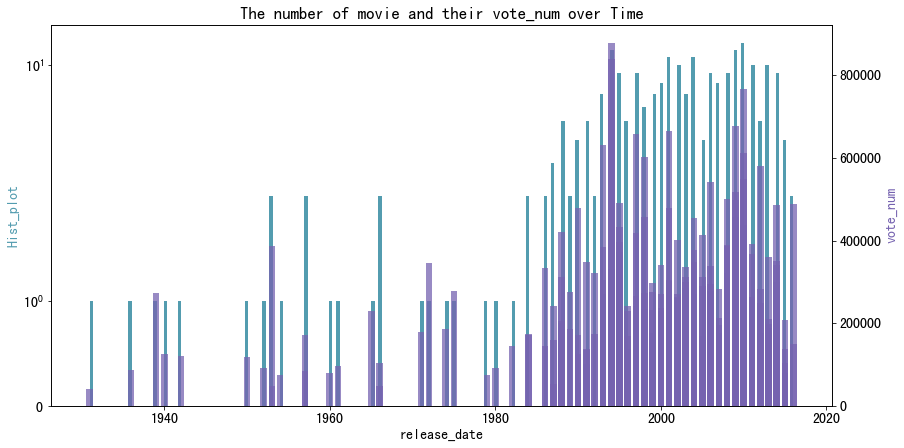

In [1118]:
from matplotlib import pyplot as plt
plot2y(x_data = data_item.release_date
           , x_label = 'release_date'
           , type1 = 'hist'
           , y1_data = data_item.vote_num #(无效果)
           , y1_color = '#539caf'
           , y1_label = 'Hist_plot'
           , type2 = 'bar'
           , y2_data = data_item.vote_num
           , y2_color = '#7663b0'
           , y2_label = 'vote_num'
           , title = 'The number of movie and their vote_num over Time')

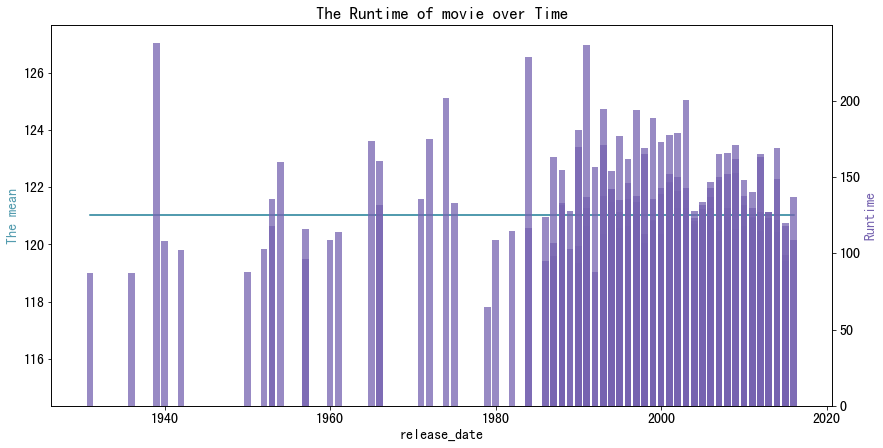

In [1119]:
plot2y(x_data = data_item.release_date
           , x_label = 'release_date'
           , type1 = 'plot'
           , y1_data = data_item.runtime.apply(lambda x : data_item.runtime.mean())
           , y1_color = '#539caf'
           , y1_label = 'The mean'
           , type2 = 'bar'
           , y2_data = data_item.runtime
           , y2_color = '#7663b0'
           , y2_label = 'Runtime'
           , title = 'The Runtime of movie over Time')

In [1120]:
# 1～5星级投票的百分比

Text(0.5, 1.0, 'Rating percent for stars 1-5')

Font 'default' does not have a glyph for '-' [U+2212], substituting with a dummy symbol.
Font 'default' does not have a glyph for '-' [U+2212], substituting with a dummy symbol.
Font 'default' does not have a glyph for '-' [U+2212], substituting with a dummy symbol.
Font 'default' does not have a glyph for '-' [U+2212], substituting with a dummy symbol.
Font 'default' does not have a glyph for '-' [U+2212], substituting with a dummy symbol.
Font 'default' does not have a glyph for '-' [U+2212], substituting with a dummy symbol.
Font 'default' does not have a glyph for '-' [U+2212], substituting with a dummy symbol.
Font 'default' does not have a glyph for '-' [U+2212], substituting with a dummy symbol.
Font 'default' does not have a glyph for '-' [U+2212], substituting with a dummy symbol.
Font 'default' does not have a glyph for '-' [U+2212], substituting with a dummy symbol.
Font 'default' does not have a glyph for '-' [U+2212], substituting with a dummy symbol.
Font 'default' does n

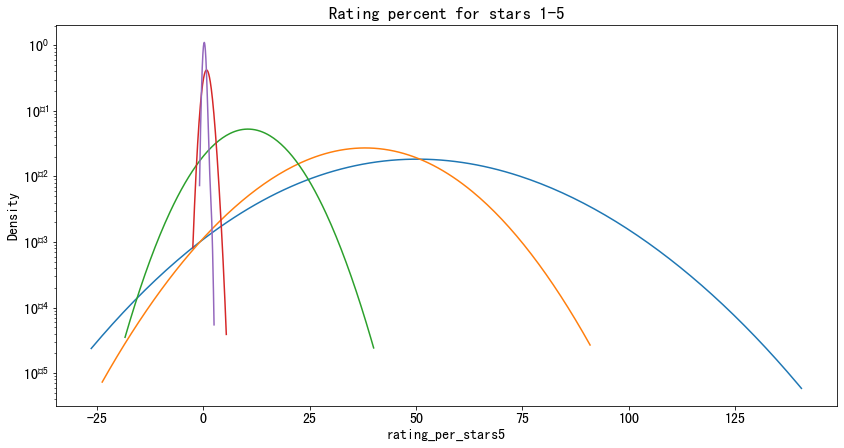

In [1121]:
sns.kdeplot(data_item.rating_per_stars5, bw=2)
sns.kdeplot(data_item.rating_per_stars4, bw=2)
sns.kdeplot(data_item.rating_per_stars3, bw=2)
sns.kdeplot(data_item.rating_per_stars2, bw=2)
sns.kdeplot(data_item.rating_per_stars1, bw=2)
plt.yscale('log')
plt.title('Rating percent for stars 1-5')

In [1122]:
# 电影简介的情感分析

In [1123]:
import warnings
warnings.filterwarnings("ignore")
import jieba   # 分词包
import numpy as np
# import codecs
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline
import matplotlib
matplotlib.rcParams['figure.figsize']=(10.0,5.0)
from wordcloud import WordCloud # 词云包

In [1124]:
# 导入、分词、去停用词 
def lcut(Intro_movie):
    segment=[]
    segs = jieba.lcut(Intro_movie) # jiaba.lcut()   
    for seg in segs:
        if len(seg)>1 and seg!='\r\n':
            segment.append(seg)
    return segment

def dropstopword(segment):
    # 去停用词
    words_df = pd.DataFrame({'segment':segment})
    stopwords = pd.read_csv("../stopwords.txt" 
                      ,index_col=False
                      ,quoting=3
                      ,sep="\t"
                      ,names=['stopword']
                      ,encoding='utf-8') # quoting=3 全不引用    
    #stopwords.head()
    return words_df[~words_df.segment.isin(stopwords.stopword)].segment.values.tolist()

In [1125]:
# 基于TextRank算法的关键词抽取(仅动词和动名词)
import jieba.analyse as analyse

data_item['keywords'] = data_item.intro.apply(lcut)\
                .apply(dropstopword)\
                .apply(lambda x : " ".join(x))\
                .apply(lambda x:" ".join(analyse.textrank(x, topK=8, withWeight=False, allowPOS=('n','ns','vn', 'v'))))
data_item.sort_values('rating_num', ascending=False)[['movie_title','keywords']].head(10)

,movie_title,keywords
243,肖申克的救赎 The Shawshank Redemption,监狱 希望 本片 惩罚 牢狱 管理层 接近 杀害
236,控方证人 Witness for the Prosecution,律师 嫌疑犯 遗嘱 警方 护士 刑案 爵士 本片
102,美丽人生 La vita è bella,儿子 圭多 法西斯 早安 公主 政权 游戏 妻子
98,霸王别姬,人生 程蝶衣 关系 风云 升级 变迁 本质 情仇
107,十二怒汉 12 Angry Men,陪审员 有罪 陪审团 被告 父亲 过程 证人 涉嫌
103,阿甘正传 Forrest Gump,妈妈 外交 美国 性格 坚强 至爱 离别 思念
101,这个杀手不太冷 Léon,女孩 邻居家 杀害 警方 缉毒 混杂着 暂避 救回
100,辛德勒的名单 Schindler's List,统治 工厂 德国 屠杀 军官 贿赂 拯救 出众
108,机器人总动员 WALL·E,地球 漫长 机器人 垃圾 公司 生活 飞船 蟑螂
120,海豚湾 The Cove,海豚 拯救 太地 渔民 渔村 县太地 景色 理查德


### 2. 处理movie_comment

In [1126]:
import pandas as pd
import numpy as np
import json
# 短评数据
movie_comment_file = ['../douban_movie/data/movie_comment%s.json' %j for j in [ i for i in range(20,220,20)] +[225,250]]
com = []
for f in movie_comment_file:
    lines = open(f, 'rb').readlines()
    com.extend([json.loads(elem.decode("utf-8")) for elem in lines])
data_com = pd.DataFrame(com)
print(data_com)
data_com['movie_id'] = data_com['movie_id'].apply(lambda x: int(x[0][5:]))
data_com['content'] = data_com.content.apply(lambda x: x[0].strip())
data_com['people'] = data_com.people.apply(lambda x: x.strip())
data_com['people'] = data_com.people_url.apply(lambda x: x[30:-1])
data_com['useful_num'] = data_com.useful_num.apply(lambda x: int(x))
def regular_nonstar(x):
    if x == 'comment-time':
        return 'allstar00 rating'
    else:
        return x
data_com['star'] = data_com.star.apply(regular_nonstar).apply(lambda x: int(x[7]))
data_com['time'] = pd.to_datetime(data_com.time.apply(lambda x: x[0]))
print('获取的总短评数：' ,data_com.shape[0])

              movie_id                                                URL  \
0       [cbtn-1292052]  https://movie.douban.com/subject/1292052/comments   
1       [cbtn-1292052]  https://movie.douban.com/subject/1292052/comments   
2       [cbtn-1292052]  https://movie.douban.com/subject/1292052/comments   
3       [cbtn-1292052]  https://movie.douban.com/subject/1292052/comments   
4       [cbtn-1292052]  https://movie.douban.com/subject/1292052/comments   
...                ...                                                ...   
249555  [cbtn-3541415]  https://movie.douban.com/subject/3541415/comme...   
249556  [cbtn-3541415]  https://movie.douban.com/subject/3541415/comme...   
249557  [cbtn-3541415]  https://movie.douban.com/subject/3541415/comme...   
249558  [cbtn-3541415]  https://movie.douban.com/subject/3541415/comme...   
249559  [cbtn-3541415]  https://movie.douban.com/subject/3541415/comme...   

                    star                                            content

In [1127]:
data_com = data_com[~data_com.comment_id.duplicated()]
print('去重后的总短评数：' ,data_com.shape[0])

people_url = data_com.people_url.unique().tolist()
np.savetxt('../douban_movie/bin/people_url.out', people_url, fmt='%s')
urllist = np.loadtxt('../douban_movie/bin/people_url.out', dtype='|S').tolist()
len(urllist)

去重后的总短评数： 249512


38599

In [1128]:
data_com = data_com.drop(['URL','people_url'], axis=1)
print(data_com.head(1))
data_com['label'] = (data_com.star >=3) *1

   movie_id  star     content  comment_id    people  useful_num  \
0   1292052     5  不需要女主角的好电影     2050003  kingfish       11314   

                 time  
0 2006-03-22 12:38:09  


In [1129]:
data_com.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 249512 entries, 0 to 249559
Data columns (total 8 columns):
 #   Column      Non-Null Count   Dtype         
---  ------      --------------   -----         
 0   movie_id    249512 non-null  int64         
 1   star        249512 non-null  int64         
 2   content     249512 non-null  object        
 3   comment_id  249512 non-null  int64         
 4   people      249512 non-null  object        
 5   useful_num  249512 non-null  int64         
 6   time        249512 non-null  datetime64[ns]
 7   label       249512 non-null  int64         
dtypes: datetime64[ns](1), int64(5), object(2)
memory usage: 17.1+ MB


In [1130]:
data_com.head(2)

,movie_id,star,content,comment_id,people,useful_num,time,label
0,1292052,5,不需要女主角的好电影,2050003,kingfish,11314,2006-03-22 12:38:09,1
1,1292052,5,恐惧让你沦为囚犯，希望让你重获自由。——《肖申克的救赎》,32514679,ruxiaoguo,7277,2008-02-27 21:43:23,1


In [1131]:
import warnings
warnings.filterwarnings("ignore")
import jieba   # 分词包
import numpy
import codecs
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline
import matplotlib
matplotlib.rc('figure', figsize = (14, 7))
matplotlib.rc('font', size = 14)
matplotlib.rc('axes', grid = False)
matplotlib.rc('axes', facecolor = 'white')
from wordcloud import WordCloud # 词云包

In [1132]:
def cut_word(content):
    # 导入、分词
    segment=[]
    for line in content: 
        try:
            segs = jieba.lcut(line) # jiaba.lcut() 
#             print(segs)
            for seg in segs:
                if len(seg)>1 and seg!='\r\n':
                    segment.append(seg)
        except:
            print(line)
            continue
#     print('cut_word', segment[:1000])
    return segment
cut_word(['阔别三十多年的同学，生活在不同的地方，有才华横溢事业有成的，有投资有方商海弄潮的，也有固守田园风光难舍故乡'])

['阔别',
 '三十多年',
 '同学',
 '生活',
 '不同',
 '地方',
 '才华横溢',
 '事业有成',
 '投资',
 '有方',
 '商海',
 '弄潮',
 '固守',
 '田园风光',
 '难舍',
 '故乡']

In [1133]:
#tf-idf
from sklearn.feature_extraction.text import TfidfVectorizer
def tf_idf_words(segment):
    content = ' '.join(segment)
    cv = TfidfVectorizer()
    cv.fit_transform([content])
#     print(content[:1000])
#     print(cv.get_feature_names())
    return cv.get_feature_names()
# tf_idf_words(['三十多年', '不同', '事业有成', '同学', '商海', '固守', '地方', '弄潮', '才华横溢', '投资', '故乡', '有方'])

In [1134]:
def remove_stopword(segment):
    # 去停用词
    words_df = pd.DataFrame({'segment':segment})
    stopwords = pd.read_csv("../stopwords.txt" 
                          ,index_col=False
                          ,quoting=3
                          ,sep="\t"
                          ,names=['stopword']
                          ,encoding='utf-8') # quoting=3 全不引用    
    words_df=words_df[~words_df.segment.isin(stopwords.stopword)]
    return words_df

In [1135]:
# 统计词频
def get_word_count(words_df):
    words_stat = words_df.groupby('segment').agg(计数=pd.NamedAgg(column='segment', aggfunc='size')).reset_index().sort_values(by='计数', ascending=False)
    return words_stat

In [1136]:
# 词云展示
import imageio
matplotlib.rcParams['figure.figsize']=(10.0,10.0)
from wordcloud import WordCloud,ImageColorGenerator
def createWordCloud(imgPath, words_stat={}):
    bimg=imageio.imread('cover.jpg')
    wordcloud=WordCloud(background_color="white",mask=bimg,font_path='../simhei.ttf',max_font_size=200)
    word_frequence={x[0]:x[1] for x in words_stat.head(1000).values}
    wordcloud=wordcloud.fit_words(word_frequence)
    bimgColors=ImageColorGenerator(bimg)
    plt.axis("off")
    plt.imshow(wordcloud.recolor(color_func=bimgColors))

In [1137]:
def createWordCloudByGenre(content, imgPath='cover.jpg'):
    segment = cut_word(content)
#     print('segment', segment)
#     segment = tf_idf_words(segment)
#     print('segment', segment)
    words_df = remove_stopword(segment)
    words_stat = get_word_count(words_df)
    createWordCloud(imgPath,words_stat=words_stat)

In [1138]:
# 合并电影短评
movie_comment_data = pd.merge(data_item, data_com, on="movie_id")

In [1139]:
# 对最受欢迎的前五条电影类别进行分析
movie_top_five = movie_type_list.head(5).index
print(movie_top_five)
# movie_type={x: x.index for x in movie_type_list}
# print(movie_type)
# # 获取方式某个题材的影评
def get_comment(genre):
    flag = movie_comment_data['genre'].apply(lambda x: str(x)).str.contains(genre)
    content = movie_comment_data[flag].content
    return content

Index(['剧情', '爱情', '喜剧', '犯罪', '动作'], dtype='object')


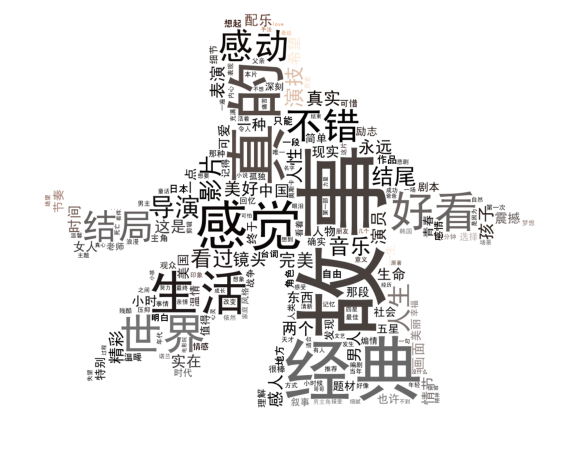

In [1140]:
# 词云展示最受欢迎的五个类型评论
comment = get_comment('剧情').values.tolist()
createWordCloudByGenre(comment)

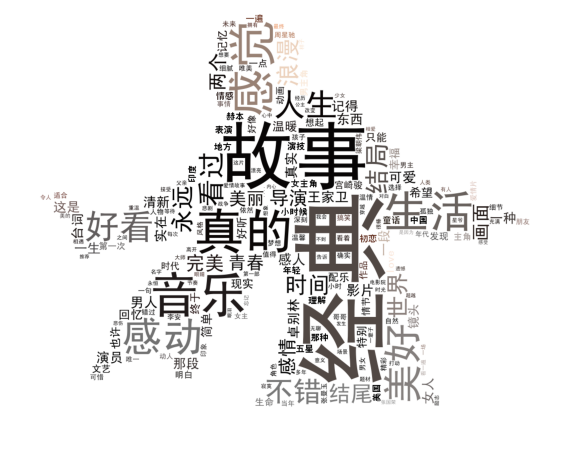

In [1141]:
comment = get_comment('爱情').values.tolist()
createWordCloudByGenre(comment)

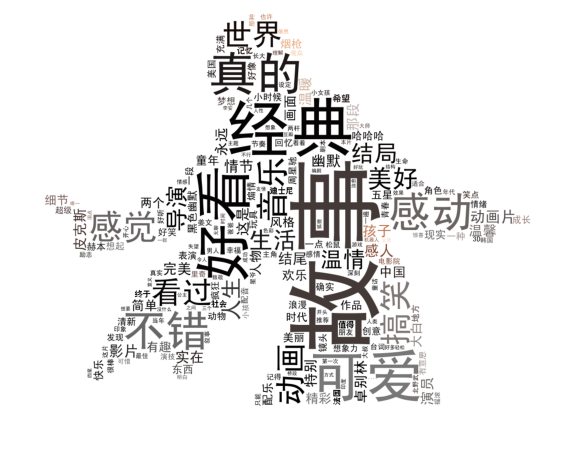

In [1142]:
comment = get_comment('喜剧').values.tolist()
createWordCloudByGenre(comment)

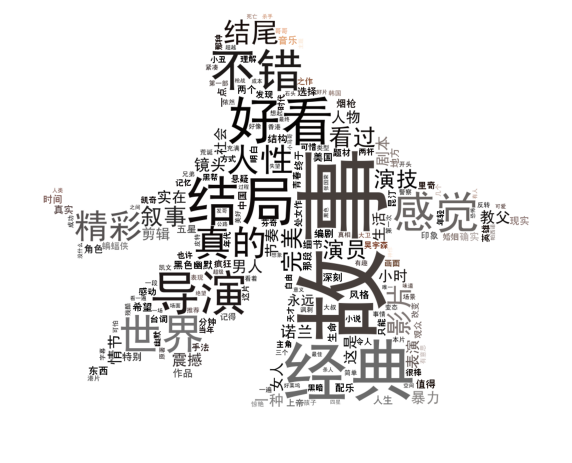

In [1143]:
comment = get_comment('犯罪').values.tolist()
createWordCloudByGenre(comment)

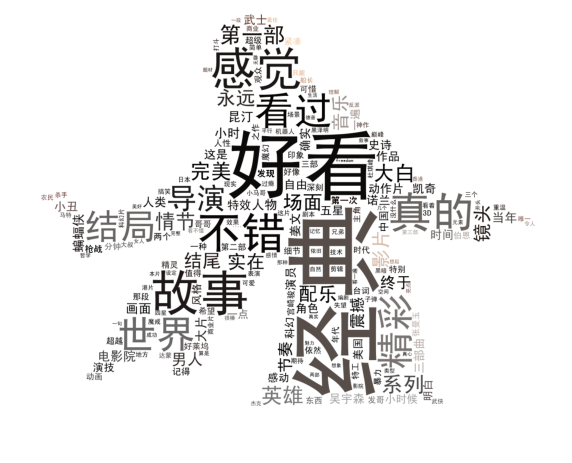

In [1144]:
comment = get_comment('动作').values.tolist()
createWordCloudByGenre(comment)

In [1145]:
# tf-dif

Text(0.5, 0, 'Number of short_comment of each movie')

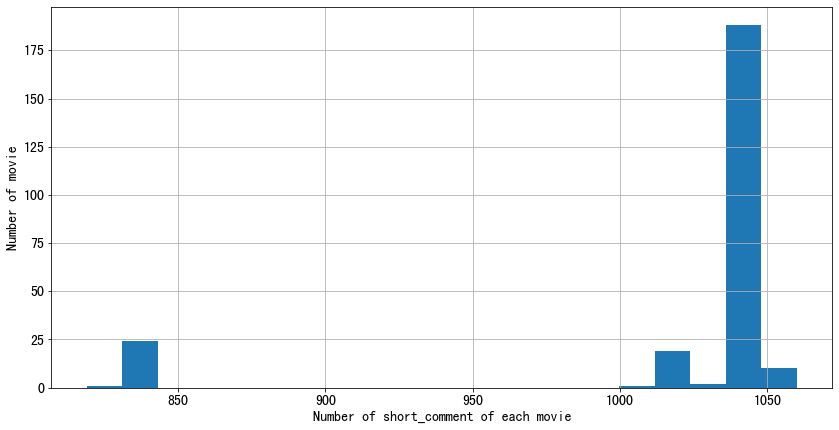

In [1146]:
from __future__ import division, print_function
from matplotlib import pyplot as plt
%matplotlib inline
import matplotlib
import seaborn as sns
matplotlib.rc('figure', figsize = (14, 7))
matplotlib.rc('font', size = 14)
matplotlib.rc('axes', grid = False)
matplotlib.rc('axes', facecolor = 'white')

data_com.movie_id.value_counts().hist(bins=20)
plt.ylabel('Number of movie')
plt.xlabel('Number of short_comment of each movie')

In [1147]:
# 1. 就《肖申克的救赎》这个电影而言

In [1148]:
data_com_X = data_com[data_com.movie_id == 1292052]
print(data_com_X.head(10))
print('爬取《肖申克的救赎》的短评数：', data_com_X.shape[0])

   movie_id  star                                            content  \
0   1292052     5                                         不需要女主角的好电影   
1   1292052     5                       恐惧让你沦为囚犯，希望让你重获自由。——《肖申克的救赎》   
2   1292052     5                                        策划了19年的私奔……   
3   1292052     5  当年的奥斯卡颁奖礼上，被如日中天的《阿甘正传》掩盖了它的光彩，而随着时间的推移，这部电影在越...   
4   1292052     5                                       关于希望最强有力的注释。   
5   1292052     5                                          有种鸟是关不住的.   
6   1292052     5                                    忒经典的东西,我要带去我的坟墓   
7   1292052     5                                超级喜欢超级喜欢,不看的话人生不圆满.   
8   1292052     5  “这是一部男人必看的电影。”人人都这么说。但单纯从性别区分，就会让这电影变狭隘。《肖申克的救...   
9   1292052     2                                      真的不喜欢，不好看，没感觉   

   comment_id           people  useful_num                time  label  
0     2050003         kingfish       11314 2006-03-22 12:38:09      1  
1    32514679        ruxiaoguo        7277 2008-02-27 21:43:23 

In [1149]:
from __future__ import division, print_function
from matplotlib import pyplot as plt
%matplotlib inline
import matplotlib
import seaborn as sns
matplotlib.rc('figure', figsize = (14, 7))
matplotlib.rc('font', size = 14)
matplotlib.rc('axes', grid = False)
matplotlib.rc('axes', facecolor = 'white')

Text(0, 0.5, 'Number of short_comment')

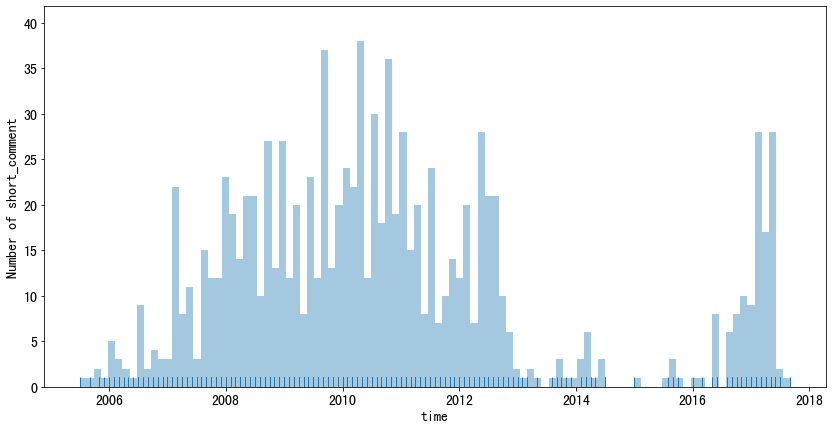

In [1150]:
sns.distplot(data_com_X.time.apply(lambda x: int(x.year)+float(x.month/12.0)), bins=100, kde=False, rug=True)
plt.xlabel('time')
plt.ylabel('Number of short_comment')

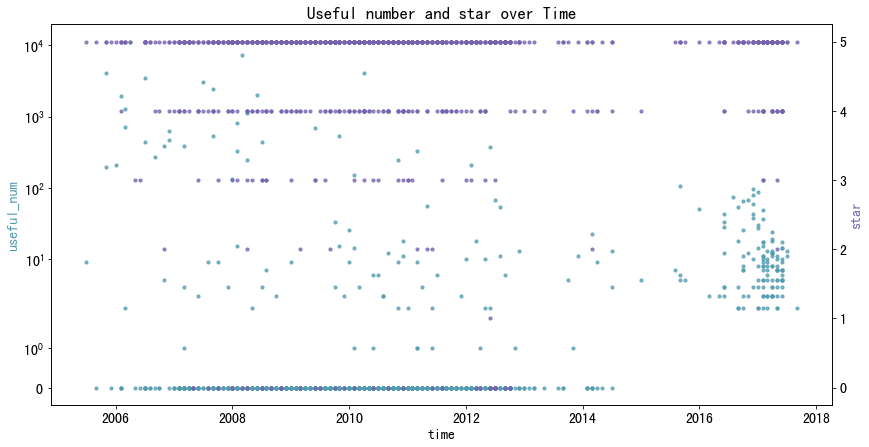

In [1151]:
plot2y(x_data = data_com_X.time.apply(lambda x: int(x.year)+float(x.month/12.0))
           , x_label = 'time'
           , type1 = 'scatter'
           , y1_data = data_com_X['useful_num']
           , y1_color = '#539caf'
           , y1_label = 'useful_num'
           , type2 = 'scatter'
           , y2_data = data_com_X['star']
           , y2_color = '#7663b0'
           , y2_label = 'star'
           , title = 'Useful number and star over Time')

In [1152]:
# 短评词云

In [1153]:
import warnings
warnings.filterwarnings("ignore")
import jieba   # 分词包
import numpy
import codecs
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline
import matplotlib
matplotlib.rc('figure', figsize = (14, 7))
matplotlib.rc('font', size = 14)
matplotlib.rc('axes', grid = False)
matplotlib.rc('axes', facecolor = 'white')
from wordcloud import WordCloud # 词云包

In [1154]:
content_X = data_com_X.content.dropna().values.tolist()
print(content_X)
# 导入、分词
segment=[]
for line in content_X: 
    try:
        segs = jieba.lcut(line) # jiaba.lcut()   
        for seg in segs:
            if len(seg)>1 and seg!='\r\n':
                segment.append(seg)
    except:
        print(line)
        continue

['不需要女主角的好电影', '恐惧让你沦为囚犯，希望让你重获自由。——《肖申克的救赎》', '策划了19年的私奔……', '当年的奥斯卡颁奖礼上，被如日中天的《阿甘正传》掩盖了它的光彩，而随着时间的推移，这部电影在越来越多的人们心中的地位已超越了《阿甘》。每当现实令我疲惫得产生无力感，翻出这张碟，就重获力量。毫无疑问，本片位列男人必看的电影前三名！回顾那一段经典台词：“有的人的羽翼是如此光辉，即使世界上最黑暗的牢狱，也无法长久地将他围困！”', '关于希望最强有力的注释。', '有种鸟是关不住的.', '忒经典的东西,我要带去我的坟墓', '超级喜欢超级喜欢,不看的话人生不圆满.', '“这是一部男人必看的电影。”人人都这么说。但单纯从性别区分，就会让这电影变狭隘。《肖申克的救赎》突破了男人电影的局限，通篇几乎充满令人难以置信的温馨基调，而电影里最伟大的主题是“希望”。\r\n当我们无奈地遇到了如同肖申克一般囚禁了心灵自由的那种囹圄，我们是无奈的老布鲁克，灰心的瑞德，还是智慧的安迪？运用智慧，信任希望，并且勇敢面对恐惧心理，去打败它？\r\n经典的电影之所以经典，因为他们都在做同一件事——让你从不同的角度来欣赏希望的美好。', '真的不喜欢，不好看，没感觉', '这无疑是我看得最多的一部经典,爱死', '点在哪？浅白的励志片诶', '人的生命不过是从一个洞穴通往另一个世界..然后在那个世界的雨中继续颤抖.i hope', 'Fear Can Hold You Prisoner, Hope Can Set You Free', '没有人会不喜欢吧！书和电影都好。', 'Hope is a good thing, and maybe the best thing of all.', '越狱我感觉就是改编自这个', '看完让人很振奋', '有那么好吗？？？？？', '在我的心目中,它一直都是最被高估的电影。', 'hope is a good thing', '大众经典我从不感冒，为什么？我欣赏水平不行？', '我最喜欢的电影', '一部没有爱情与美女的电影,却光芒四射', '这样的男人谁会舍得背叛。。。', '酣畅淋漓', '不多说了', '因为1994年台湾引进了一部比较卖座的老片The Sting，被错译成了《刺激》。到了1995年本片上映时，片商觉得其剧情与《刺

In [1277]:
# 去停用词
words_df = pd.DataFrame({'segment':segment})
stopwords = pd.read_csv("../stopwords.txt" 
                      ,index_col=False
                      ,quoting=3
                      ,sep="\t"
                      ,names=['stopword']
                      ,encoding='utf-8') # quoting=3 全不引用    
#stopwords.head()
print(words_df.segment)
words_df=words_df[~words_df.segment.isin(stopwords.stopword)]

0     需要
1    女主角
2     电影
Name: segment, dtype: object


In [1156]:
# 统计词频
# words_stat = words_df.groupby(by=['segment'])['segment'].agg({"计数":np.size})
# words_stat=words_stat.reset_index().sort_values(by=["计数"],ascending=False
words_stat = words_df.groupby('segment').agg(计数=pd.NamedAgg(column='segment', aggfunc='size')).reset_index().sort_values(by='计数', ascending=False)
print(words_stat.segment.tolist())
#words_stat.head()

['希望', '经典', '自由', '越狱', '救赎', '真的', '监狱', '看过', 'thing', '好看', '信念', '震撼', 'good', '美好', '男人', '安迪', '人生', '励志', '东西', 'Hope', '肖申克', '故事', '感觉', 'busy', 'hope', '生活', '结局', '时间', '必看', '黑暗', '世界', '不错', '影片', '渴望', '生命', '完美', '永远', '绝望', '精彩', '力量', '阿甘', '值得', '一种', '只能', '社会', '终于', '向往', '放弃', '这是', '体制', '关不住', '五星', '刺激', '原著', '也许', '光辉', 'living', '重获', '第一', '小说', '环境', '面对', 'dying', '一遍', '很棒', '没什么', '梦想', '羽毛', '第一次', '内心', '确实', '豆瓣', '人性', '超级', '瑞德', '明白', '智慧', '多年', '两个', '活着', '评价', '鸟儿', '弗里', '强大', '囚禁', '四星', '友情', '成功', '圣经', '自我', '地方', '无冕之王', '阿甘正传', '每次', '心中', '心灵', '毅力', '本片', '恐惧', '感受', 'things', '知识', '好片', '精神', 'imdb', 'Andy', '深刻', '发现', '美国', '羽翼', '意义', '努力', '永不', '充满', '作品', '1995', '超越', '事情', 'Get', '习惯', '之作', '电影版', '类型', '当年', '改变', '想要', '演员', '推荐', '永恒', '排名', '神作', '出狱', '几遍', '蒂姆', '罗宾斯', '基督山', 'IMDB', '大海', '追求', '表演', '失望', '自杀', 'dies', '牢狱', '解释', '聪明', '印象', '那种', '厉害', '笼子', '影响', '沦为', '囚犯', '情节', '变得', '命运', '可怕', '满分', '灵魂', '

word_frequence {'希望': 137, '经典': 127, '自由': 111, '越狱': 53, '救赎': 43, '真的': 40, '监狱': 34, '看过': 31, 'thing': 30, '好看': 30, '信念': 29, '震撼': 27, 'good': 27, '美好': 24, '男人': 23, '安迪': 22, '人生': 22, '励志': 21, '东西': 21, 'Hope': 20, '肖申克': 20, '故事': 19, '感觉': 18, 'busy': 16, 'hope': 16, '生活': 16, '结局': 16, '时间': 15, '必看': 14, '黑暗': 14, '世界': 14, '不错': 14, '影片': 13, '渴望': 13, '生命': 13, '完美': 13, '永远': 13, '绝望': 13, '精彩': 12, '力量': 12, '阿甘': 11, '值得': 11, '一种': 11, '只能': 11, '社会': 11, '终于': 11, '向往': 11, '放弃': 11, '这是': 10, '体制': 10, '关不住': 10, '五星': 10, '刺激': 10, '原著': 10, '也许': 10, '光辉': 10, 'living': 9, '重获': 9, '第一': 9, '小说': 9, '环境': 9, '面对': 9, 'dying': 9, '一遍': 9, '很棒': 9, '没什么': 9, '梦想': 9, '羽毛': 8, '第一次': 8, '内心': 8, '确实': 8, '豆瓣': 8, '人性': 8, '超级': 8, '瑞德': 8, '明白': 8, '智慧': 8, '多年': 8, '两个': 8, '活着': 7, '评价': 7, '鸟儿': 7, '弗里': 7, '强大': 7, '囚禁': 7, '四星': 7, '友情': 7, '成功': 7, '圣经': 7, '自我': 7, '地方': 7, '无冕之王': 7, '阿甘正传': 7, '每次': 7, '心中': 7, '心灵': 7, '毅力': 7, '本片': 7, '恐惧': 7, '感受': 6,

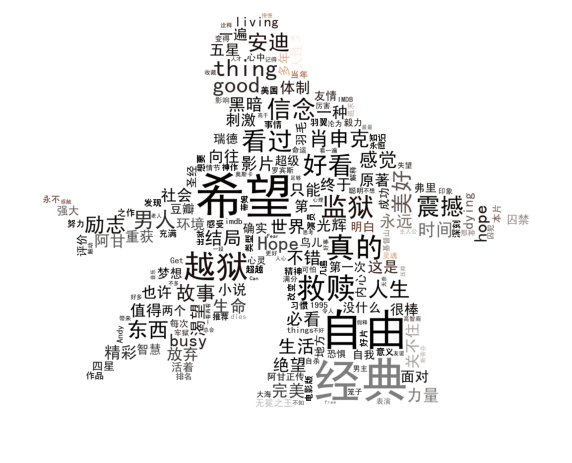

In [1157]:
# 加入自定义图
# from scipy.misc import 
import imageio
matplotlib.rcParams['figure.figsize']=(10.0,10.0)
from wordcloud import WordCloud,ImageColorGenerator
bimg=imageio.imread('cover.jpg')
wordcloud=WordCloud(background_color="white",mask=bimg,font_path='../simhei.ttf',max_font_size=100)
word_frequence={x[0]:x[1] for x in words_stat.head(1000).values}
print('word_frequence', word_frequence)
wordcloud=wordcloud.fit_words(word_frequence)
bimgColors=ImageColorGenerator(bimg)
plt.axis("off")
plt.imshow(wordcloud.recolor(color_func=bimgColors))

In [1158]:
# 用朴素贝叶斯完成中文文本分类器

In [1159]:
data_com_X.label.value_counts()
print(data_com_X)

       movie_id  star                                            content  \
0       1292052     5                                         不需要女主角的好电影   
1       1292052     5                       恐惧让你沦为囚犯，希望让你重获自由。——《肖申克的救赎》   
2       1292052     5                                        策划了19年的私奔……   
3       1292052     5  当年的奥斯卡颁奖礼上，被如日中天的《阿甘正传》掩盖了它的光彩，而随着时间的推移，这部电影在越...   
4       1292052     5                                       关于希望最强有力的注释。   
...         ...   ...                                                ...   
20655   1292052     5                                               不多说了   
20656   1292052     5                       何谓救赎，何谓自由。斯蒂芬金写的故事总是透着人性的光辉。   
20657   1292052     5  希望真好啊~结局把我感动坏了~特别的积极向上~绝望的时候就拿来看看吧~另外男猪不仅IQ EQ...   
20658   1292052     5                                            据说还蛮好看的   
20659   1292052     5                                          不能错过，看完惊讶   

       comment_id           people  useful_num                time  label  
0         2

In [1160]:
# 词云
import warnings
warnings.filterwarnings("ignore")
import jieba   # 分词包
import numpy
import codecs
import pandas as pd

def preprocess_text(content_lines,sentences,category):
    for line in content_lines:
        try:
            segs=jieba.lcut(line)
            segs = filter(lambda x:len(x)>1, segs)
            segs = filter(lambda x:x not in stopwords, segs)
            sentences.append((" ".join(segs), category))
        except:
            print(line)
            continue

In [1161]:
data_com_X_1 = data_com_X[data_com_X.label == 1]
# print(data_com_X[data_com_X.label == 1])
data_com_X_0 = data_com_X[data_com_X.label == 0]
print(len(data_com_X[data_com_X.label == 0]))

47


In [1162]:
# 下采样
sentences=[]
# print(data_com_X_1.content.dropna().values.tolist())
preprocess_text(data_com_X_1.content.dropna().values.tolist() ,sentences ,'like')
n=0
while n <20:
    preprocess_text(data_com_X_0.content.dropna().values.tolist() ,sentences ,'nlike')
    n +=1

In [1163]:
import random
random.shuffle(sentences)
print(sentences)
for sentence in sentences[:2]:
    print(sentence[0], sentence[1])

[('希望 东西', 'nlike'), ('每个 渴望 自由', 'like'), ('后续 片子 前瞻', 'like'), ('真的 喜欢 好看 感觉', 'nlike'), ('喜欢', 'like'), ('努力 样子', 'like'), ('那么', 'nlike'), ('这部 电影 没什么 史上 完美 电影 没有 一秒 时间', 'like'), ('蒂姆 罗宾斯 最后 仰天 大叫 以为 电影 行将 结束 最后 弗里 蒂姆 相聚 终点 充满 情义', 'like'), ('明明 勇敢 心式 狗血', 'nlike'), ('那么', 'nlike'), ('最后 那片海 美的 晕眩', 'like'), ('深深 回味 电影', 'like'), ('解救 只是 自己', 'nlike'), ('当年 越狱 以后 一部 顿时 觉得 越狱 其实 那么', 'like'), ('学校 感慨 良多 电影', 'like'), ('never thought out Shawshank can run out of the jail At the end of the movie the escape make me scared about the patience the plan the power realization of the dream Nice for Shawshank and it nice for everyone', 'nlike'), ('因为 1994 台湾 引进 一部 比较 卖座 老片 The Sting 译成 刺激 1995 本片 上映 片商 觉得 剧情 刺激 类似 地方 大概 属于 高智商 复仇 因此 译成 刺激 1995 1998 一部 片子 Return To Paradise 因为 含有 牢狱 情节 译成 刺激 1998', 'like'), ('希望 东西 害人 救人', 'like'), ('活着 希望 一点 没有 当老布 自杀 时候 应该 回到 监狱 度过 剩余 日子 可是 当安迪 终于 出去 时候 那么 美好 真的 希望 才能 快乐 勇敢 活下去 失意 时候 想起 这个 片子 想起 那么 努力 想尽办法 脱身 觉得 一定 可以 冲出重围 重新 起来 真的 励志', 'like'), ('如果 希望 带来 

In [1164]:
from sklearn.model_selection import StratifiedKFold
from sklearn.naive_bayes import MultinomialNB
from sklearn.metrics import accuracy_score,precision_score
#from sklearn.model_selection import train_test_split
# print(sentences)
x,y=zip(*sentences) #解压
from sklearn.feature_extraction.text import CountVectorizer

vec = CountVectorizer(
    analyzer='word', # tokenise by character ngrams 
    ngram_range=(1,4), # use ngrams of size 1 and 2 
    max_features=20000, # keep the most common 1000 ngrams
)
vec.fit(x)
def stratifiedkfold_cv(x,y,clf_class,shuffle=True,n_splits=5,**kwargs):
    stratifiedk_fold = StratifiedKFold(n_splits=n_splits, shuffle=shuffle)
    y_pred = y[:]
    for train_index, test_index in stratifiedk_fold.split(x,y):
        X_train, X_test = x[train_index], x[test_index]
        y_train = y[train_index]
        clf = clf_class(**kwargs)
        clf.fit(X_train,y_train)
        y_pred[test_index] = clf.predict(X_test)
    return y_pred

NB = MultinomialNB
print(precision_score(y, stratifiedkfold_cv(vec.transform(x),np.array(y),NB), average='macro'))

0.8713824457064431


In [1165]:
import re
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.model_selection import train_test_split
from sklearn.naive_bayes import MultinomialNB

class TextClassifier():
    def __init__(self, classifier=MultinomialNB()):
        self.classifier = classifier
        self.vectorizer = CountVectorizer(analyzer='word'
                                          ,ngram_range=(1,4)
                                          ,max_features=20000)
    def features(self, X):
        return self.vectorizer.transform(X)
    
    def fit(self, X, y):
        self.vectorizer.fit(X)
        self.classifier.fit(self.features(X), y)
        
    def predict(self, x):
        return self.classifier.predict(self.features([x]))
    
    def score(self, X, y):
        return self.classifier.score(self.features(X), y)

In [1166]:
# 后期模型优化
text_classifier=TextClassifier()
x_train,x_test,y_train,y_test=train_test_split(x,y,random_state=1234)
text_classifier.fit(x_train,y_train)
print(text_classifier.predict('难得看到这么惨烈的公安警匪大战。'))
print(text_classifier.predict('无法'))
print(text_classifier.predict('好想甩出一麻袋星'))
print(text_classifier.score(x_test,y_test))

['like']
['nlike']
['like']
0.9028925619834711


3.主题分析

In [1194]:
import gensim
from gensim import corpora
import matplotlib.pyplot as plt
import matplotlib
import numpy as np
import warnings
warnings.filterwarnings('ignore')  # To ignore all warnings that arise here to enhance clarity
 
from gensim.models.coherencemodel import CoherenceModel
from gensim.models.ldamodel import LdaModel

In [1300]:
# 构建词典
# print(content_X)
data_set = []
for content in content_X:
    segment = []
    segs = jieba.lcut(content)
    stopwords = pd.read_csv("../stopwords.txt" 
                              ,index_col=False
                              ,quoting=3
                              ,sep="\t"
                              ,names=['stopword']
                              ,encoding='utf-8') # quoting=3 全不引用 
    for seg in segs:
        if len(seg)>1 and seg!='\r\n' and seg not in stopwords.stopword.values.tolist():
            segment.append(seg)
    data_set.append(segment)
# print(data_set)
dictionary = corpora.Dictionary(data_set)  # 构建词典
# print(dictionary.token2id)
corpus = [dictionary.doc2bow(text) for text in data_set]
# print(corpus)

In [1306]:
# 构建LDA模型
import pprint
num_topics = 9
ldamodel = LdaModel(corpus, num_topics=num_topics, id2word = dictionary, passes=30,random_state = 1)   #分为5个主题,text:文本，已经表示成词袋了。num_topics: 提取的主题数id2word:词典passes:类似于在机器学习中常见的epoch，也就是训练了多少轮;random_state -这是一个种子（如果您想精确地重复训练过程）。
pprint.pprint(ldamodel.print_topics(num_topics=num_topics, num_words=15))  #每个主题输出5个单词


[(0,
  '0.034*"救赎" + 0.013*"希望" + 0.011*"励志" + 0.008*"肖申克" + 0.006*"诠释" + '
  '0.005*"震撼" + 0.005*"自由" + 0.004*"绝望" + 0.004*"精彩" + 0.004*"人生" + 0.004*"梦想" '
  '+ 0.004*"几遍" + 0.004*"一种" + 0.004*"多年" + 0.004*"心理"'),
 (1,
  '0.023*"自由" + 0.015*"希望" + 0.014*"看过" + 0.014*"越狱" + 0.010*"信念" + 0.007*"生命" '
  '+ 0.006*"电影版" + 0.006*"囚犯" + 0.006*"沦为" + 0.006*"只能" + 0.006*"体制" + '
  '0.006*"精彩" + 0.006*"恐惧" + 0.006*"时间" + 0.006*"重获"'),
 (2,
  '0.102*"经典" + 0.035*"希望" + 0.011*"人生" + 0.010*"救赎" + 0.009*"监狱" + 0.008*"必看" '
  '+ 0.007*"永远" + 0.006*"影片" + 0.005*"越狱" + 0.005*"安迪" + 0.005*"真的" + '
  '0.005*"信念" + 0.005*"这是" + 0.005*"故事" + 0.005*"生命"'),
 (3,
  '0.067*"自由" + 0.020*"希望" + 0.015*"男人" + 0.015*"渴望" + 0.010*"力量" + 0.009*"震撼" '
  '+ 0.009*"真的" + 0.007*"向往" + 0.006*"励志" + 0.006*"很棒" + 0.005*"信念" + '
  '0.005*"感触" + 0.005*"好事" + 0.005*"强大" + 0.005*"經典"'),
 (4,
  '0.012*"自由" + 0.011*"超级" + 0.010*"希望" + 0.010*"感觉" + 0.009*"越狱" + 0.007*"也许" '
  '+ 0.005*"关不住" + 0.005*"活着" + 0.005*"鸟儿" + 0.005*"至善" 

In [1307]:
#计算困惑度
def perplexity(num_topics):
    ldamodel = LdaModel(corpus, num_topics=num_topics, id2word = dictionary, passes=30)
    print(ldamodel.print_topics(num_topics=num_topics, num_words=15))
    print(ldamodel.log_perplexity(corpus))
    return ldamodel.log_perplexity(corpus)
#计算coherence
def coherence(num_topics):
    ldamodel = LdaModel(corpus, num_topics=num_topics, id2word = dictionary, passes=30,random_state = 1)
    print(ldamodel.print_topics(num_topics=num_topics, num_words=10))
    ldacm = CoherenceModel(model=ldamodel, texts=data_set, dictionary=dictionary, coherence='c_v')
#     print(ldacm.get_coherence())
    return ldacm.get_coherence()

[(0, '0.019*"希望" + 0.017*"经典" + 0.015*"自由" + 0.007*"越狱" + 0.006*"救赎" + 0.006*"真的" + 0.005*"监狱" + 0.004*"看过" + 0.004*"好看" + 0.004*"thing" + 0.004*"信念" + 0.004*"震撼" + 0.004*"good" + 0.003*"美好" + 0.003*"男人"')]
-7.432296337749215
[(0, '0.030*"经典" + 0.027*"希望" + 0.011*"自由" + 0.010*"救赎" + 0.008*"thing" + 0.007*"信念" + 0.007*"good" + 0.006*"震撼" + 0.006*"美好" + 0.006*"人生" + 0.005*"东西" + 0.005*"监狱" + 0.005*"Hope" + 0.005*"故事" + 0.004*"感觉"'), (1, '0.020*"自由" + 0.016*"越狱" + 0.010*"希望" + 0.009*"好看" + 0.009*"看过" + 0.008*"真的" + 0.005*"busy" + 0.005*"励志" + 0.004*"监狱" + 0.004*"不错" + 0.004*"男人" + 0.004*"安迪" + 0.004*"力量" + 0.003*"终于" + 0.003*"时间"')]
-7.581870536814092
[(0, '0.017*"希望" + 0.014*"自由" + 0.013*"真的" + 0.006*"影片" + 0.006*"男人" + 0.006*"越狱" + 0.005*"不错" + 0.005*"值得" + 0.005*"生命" + 0.005*"经典" + 0.005*"安迪" + 0.005*"监狱" + 0.005*"必看" + 0.005*"精彩" + 0.004*"完美"'), (1, '0.039*"经典" + 0.037*"希望" + 0.028*"自由" + 0.008*"美好" + 0.007*"信念" + 0.006*"东西" + 0.006*"人生" + 0.005*"永远" + 0.005*"力量" + 0.004*"绝望" + 0.004*

[(0, '0.066*"自由" + 0.059*"希望" + 0.015*"东西" + 0.013*"生活" + 0.013*"经典" + 0.012*"渴望" + 0.012*"美好" + 0.008*"信念" + 0.007*"永远" + 0.007*"震撼" + 0.006*"监狱" + 0.006*"精彩" + 0.006*"放弃" + 0.005*"真的" + 0.005*"越狱"'), (1, '0.027*"越狱" + 0.015*"完美" + 0.012*"值得" + 0.007*"监狱" + 0.007*"圣经" + 0.007*"好片" + 0.006*"震撼" + 0.006*"社会" + 0.005*"救赎" + 0.005*"知识" + 0.005*"勇气" + 0.005*"史上" + 0.005*"鼻祖" + 0.005*"四星" + 0.005*"最最"'), (2, '0.047*"thing" + 0.042*"good" + 0.026*"Hope" + 0.014*"hope" + 0.013*"必看" + 0.012*"人生" + 0.009*"things" + 0.009*"光辉" + 0.008*"dies" + 0.006*"羽毛" + 0.006*"小说" + 0.006*"第一" + 0.006*"男人" + 0.006*"羽翼" + 0.005*"自由"'), (3, '0.027*"男人" + 0.008*"世界" + 0.006*"时间" + 0.006*"超级" + 0.006*"自由" + 0.006*"人生" + 0.005*"监狱" + 0.005*"人性" + 0.004*"希望" + 0.004*"光辉" + 0.004*"面对" + 0.004*"肖申克" + 0.004*"安迪" + 0.003*"震撼" + 0.003*"阿甘"'), (4, '0.033*"救赎" + 0.015*"希望" + 0.011*"只能" + 0.010*"励志" + 0.010*"肖申克" + 0.009*"生命" + 0.006*"监狱" + 0.006*"安迪" + 0.005*"阿甘" + 0.005*"caged" + 0.005*"Their" + 0.005*"birds" + 0.005*"b

[(0, '0.057*"thing" + 0.052*"good" + 0.038*"Hope" + 0.027*"hope" + 0.012*"things" + 0.012*"只能" + 0.010*"精彩" + 0.010*"Fear" + 0.010*"Can" + 0.010*"dies" + 0.008*"You" + 0.008*"free" + 0.008*"set" + 0.008*"一遍" + 0.006*"结局"'), (1, '0.188*"经典" + 0.037*"好看" + 0.008*"永远" + 0.008*"超级" + 0.008*"小说" + 0.008*"原著" + 0.008*"希望" + 0.008*"肖申克" + 0.006*"环境" + 0.006*"四星" + 0.006*"必看" + 0.006*"真的" + 0.005*"面对" + 0.005*"一遍" + 0.005*"抗争"'), (2, '0.023*"自由" + 0.010*"希望" + 0.010*"阿甘" + 0.010*"强大" + 0.008*"震撼" + 0.008*"越狱" + 0.008*"类型" + 0.006*"题材" + 0.006*"注定" + 0.006*"精神" + 0.006*"社会" + 0.006*"大海" + 0.004*"梦想" + 0.004*"Andy" + 0.004*"假释"'), (3, '0.024*"不错" + 0.017*"自由" + 0.012*"人生" + 0.012*"希望" + 0.012*"毅力" + 0.010*"真的" + 0.010*"努力" + 0.010*"救赎" + 0.007*"不幸" + 0.007*"不公" + 0.007*"超越" + 0.007*"命运" + 0.005*"生活" + 0.005*"一种" + 0.005*"光辉"'), (4, '0.010*"自由" + 0.009*"故事" + 0.009*"freedom" + 0.009*"没什么" + 0.007*"结局" + 0.007*"收藏" + 0.007*"feathers" + 0.007*"meant" + 0.007*"bright" + 0.007*"birds" + 0.007*"Their"

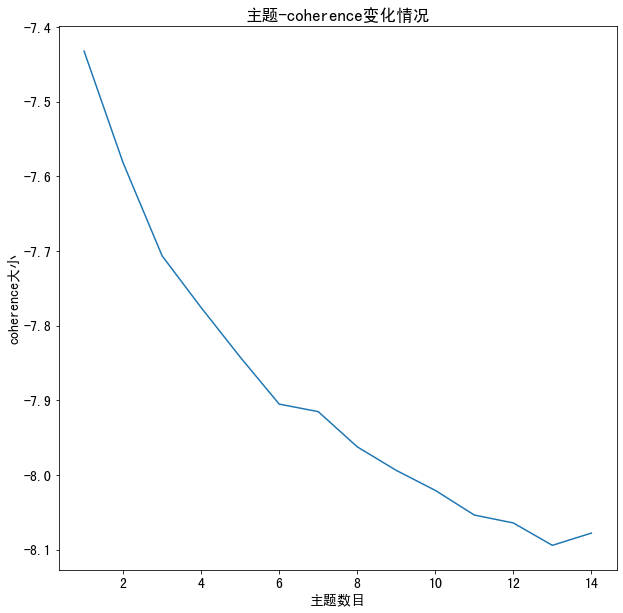

In [1308]:
# 绘制主题-coherence曲线，选择最佳主题数
x = range(1,15)
y = [perplexity(i) for i in x]  #如果想用困惑度就选这个
# y = [coherence(i) for i in x]
plt.plot(x, y)
plt.xlabel('主题数目')
plt.ylabel('coherence大小')
plt.rcParams['font.sans-serif']=['SimHei']
matplotlib.rcParams['axes.unicode_minus']=False
plt.title('主题-coherence变化情况')
plt.show()

In [1311]:
#  通过上述主题评估，我们发现可以选择3作为主题个数，接下来我们可以再跑一次模型，设定主题数为5，并输出每个文档最有可能对应的主题
from gensim.models import LdaModel
import pandas as pd
from gensim.corpora import Dictionary
from gensim import corpora, models

 
dictionary = corpora.Dictionary(data_set)  # 构建词典
corpus = [dictionary.doc2bow(text) for text in data_set]
 
lda = LdaModel(corpus=corpus, id2word=dictionary, num_topics=9, passes = 30,random_state=1)
topic_list=lda.print_topics()
pprint.pprint(topic_list)
for i in lda.get_document_topics(corpus)[:]:
    print('i==',i)
    listj=[]
    for j in i:
        print('j==', j)
        listj.append(j[1])
#     print(listj)
    bz=listj.index(max(listj))
#     print(i[bz][0])

# for topic in lda.print_topics(num_words = 20):
#     termNumber = topic[0]
#     print(topic[0], ':', sep='')
#     listOfTerms = topic[1].split('+')
#     for term in listOfTerms:
#         listItems = term.split('*')
#         print('  ', listItems[1], '(', listItems[0], ')', sep='')

[(0,
  '0.034*"救赎" + 0.013*"希望" + 0.011*"励志" + 0.008*"肖申克" + 0.006*"诠释" + '
  '0.005*"震撼" + 0.005*"自由" + 0.004*"绝望" + 0.004*"精彩" + 0.004*"人生"'),
 (1,
  '0.023*"自由" + 0.015*"希望" + 0.014*"看过" + 0.014*"越狱" + 0.010*"信念" + 0.007*"生命" '
  '+ 0.006*"电影版" + 0.006*"囚犯" + 0.006*"沦为" + 0.006*"只能"'),
 (2,
  '0.102*"经典" + 0.035*"希望" + 0.011*"人生" + 0.010*"救赎" + 0.009*"监狱" + 0.008*"必看" '
  '+ 0.007*"永远" + 0.006*"影片" + 0.005*"越狱" + 0.005*"安迪"'),
 (3,
  '0.067*"自由" + 0.020*"希望" + 0.015*"男人" + 0.015*"渴望" + 0.010*"力量" + 0.009*"震撼" '
  '+ 0.009*"真的" + 0.007*"向往" + 0.006*"励志" + 0.006*"很棒"'),
 (4,
  '0.012*"自由" + 0.011*"超级" + 0.010*"希望" + 0.010*"感觉" + 0.009*"越狱" + 0.007*"也许" '
  '+ 0.005*"关不住" + 0.005*"活着" + 0.005*"鸟儿" + 0.005*"至善"'),
 (5,
  '0.039*"越狱" + 0.023*"希望" + 0.012*"生活" + 0.011*"自由" + 0.009*"评价" + 0.008*"值得" '
  '+ 0.008*"绝望" + 0.008*"男人" + 0.008*"完美" + 0.006*"神作"'),
 (6,
  '0.018*"busy" + 0.010*"dying" + 0.010*"living" + 0.009*"自由" + 0.009*"故事" + '
  '0.008*"真的" + 0.008*"希望" + 0.008*"监狱" + 0.007*"

i== [(0, 0.015878389), (1, 0.015884796), (2, 0.015878906), (3, 0.3577936), (4, 0.015876958), (5, 0.015879726), (6, 0.015882526), (7, 0.015877554), (8, 0.5310476)]
j== (0, 0.015878389)
j== (1, 0.015884796)
j== (2, 0.015878906)
j== (3, 0.3577936)
j== (4, 0.015876958)
j== (5, 0.015879726)
j== (6, 0.015882526)
j== (7, 0.015877554)
j== (8, 0.5310476)
i== [(0, 0.012347822), (1, 0.0123503255), (2, 0.012349887), (3, 0.012355456), (4, 0.012348278), (5, 0.90119296), (6, 0.012347904), (7, 0.01236019), (8, 0.0123471655)]
j== (0, 0.012347822)
j== (1, 0.0123503255)
j== (2, 0.012349887)
j== (3, 0.012355456)
j== (4, 0.012348278)
j== (5, 0.90119296)
j== (6, 0.012347904)
j== (7, 0.01236019)
j== (8, 0.0123471655)
i== [(0, 0.43246776), (7, 0.53760254)]
j== (0, 0.43246776)
j== (7, 0.53760254)
i== [(0, 0.02777921), (1, 0.027780117), (2, 0.027783517), (3, 0.027782371), (4, 0.027790155), (5, 0.027780253), (6, 0.027782153), (7, 0.7777435), (8, 0.027778665)]
j== (0, 0.02777921)
j== (1, 0.027780117)
j== (2, 0.02

j== (0, 0.05555699)
j== (1, 0.05555699)
j== (2, 0.055575028)
j== (3, 0.5554989)
j== (4, 0.05555699)
j== (5, 0.05555699)
j== (6, 0.05555699)
j== (7, 0.055575088)
j== (8, 0.05556604)
i== [(0, 0.018520592), (1, 0.01853508), (2, 0.018526657), (3, 0.018526055), (4, 0.85179347), (5, 0.018523458), (6, 0.018522948), (7, 0.01853116), (8, 0.018520592)]
j== (0, 0.018520592)
j== (1, 0.01853508)
j== (2, 0.018526657)
j== (3, 0.018526055)
j== (4, 0.85179347)
j== (5, 0.018523458)
j== (6, 0.018522948)
j== (7, 0.01853116)
j== (8, 0.018520592)
i== [(0, 0.055559315), (1, 0.055576663), (2, 0.05555826), (3, 0.5554839), (4, 0.05556574), (5, 0.055565123), (6, 0.055563558), (7, 0.05556832), (8, 0.055559166)]
j== (0, 0.055559315)
j== (1, 0.055576663)
j== (2, 0.05555826)
j== (3, 0.5554839)
j== (4, 0.05556574)
j== (5, 0.055565123)
j== (6, 0.055563558)
j== (7, 0.05556832)
j== (8, 0.055559166)
i== [(0, 0.05555663), (1, 0.05555663), (2, 0.5554877), (3, 0.05555663), (4, 0.05555663), (5, 0.055578735), (6, 0.05555663),

j== (6, 0.055565428)
j== (7, 0.055565428)
j== (8, 0.55547655)
i== [(0, 0.03704032), (1, 0.03704032), (2, 0.03704032), (3, 0.70366716), (4, 0.03704032), (5, 0.03704032), (6, 0.037046228), (7, 0.0370447), (8, 0.03704032)]
j== (0, 0.03704032)
j== (1, 0.03704032)
j== (2, 0.03704032)
j== (3, 0.70366716)
j== (4, 0.03704032)
j== (5, 0.03704032)
j== (6, 0.037046228)
j== (7, 0.0370447)
j== (8, 0.03704032)
i== [(0, 0.11111111), (1, 0.11111111), (2, 0.11111111), (3, 0.11111111), (4, 0.11111111), (5, 0.11111111), (6, 0.11111111), (7, 0.11111111), (8, 0.11111111)]
j== (0, 0.11111111)
j== (1, 0.11111111)
j== (2, 0.11111111)
j== (3, 0.11111111)
j== (4, 0.11111111)
j== (5, 0.11111111)
j== (6, 0.11111111)
j== (7, 0.11111111)
j== (8, 0.11111111)
i== [(0, 0.022227041), (1, 0.022226974), (2, 0.8221914), (3, 0.022225898), (4, 0.022226142), (5, 0.022225473), (6, 0.02222584), (7, 0.022225745), (8, 0.022225471)]
j== (0, 0.022227041)
j== (1, 0.022226974)
j== (2, 0.8221914)
j== (3, 0.022225898)
j== (4, 0.022226

j== (0, 0.027785614)
j== (1, 0.027780378)
j== (2, 0.027780378)
j== (3, 0.027780378)
j== (4, 0.027799385)
j== (5, 0.027790543)
j== (6, 0.027788915)
j== (7, 0.027782947)
j== (8, 0.77771145)
i== [(0, 0.11111111), (1, 0.11111111), (2, 0.11111111), (3, 0.11111111), (4, 0.11111111), (5, 0.11111111), (6, 0.11111111), (7, 0.11111111), (8, 0.11111111)]
j== (0, 0.11111111)
j== (1, 0.11111111)
j== (2, 0.11111111)
j== (3, 0.11111111)
j== (4, 0.11111111)
j== (5, 0.11111111)
j== (6, 0.11111111)
j== (7, 0.11111111)
j== (8, 0.11111111)
i== [(0, 0.027784063), (1, 0.027784515), (2, 0.7777224), (3, 0.027785683), (4, 0.027783372), (5, 0.027786434), (6, 0.02778296), (7, 0.027788375), (8, 0.027782198)]
j== (0, 0.027784063)
j== (1, 0.027784515)
j== (2, 0.7777224)
j== (3, 0.027785683)
j== (4, 0.027783372)
j== (5, 0.027786434)
j== (6, 0.02778296)
j== (7, 0.027788375)
j== (8, 0.027782198)
i== [(0, 0.037048686), (1, 0.037055194), (2, 0.037074402), (3, 0.703554), (4, 0.03704773), (5, 0.037059803), (6, 0.03704553)

j== (3, 0.05556051)
j== (4, 0.05556051)
j== (5, 0.05556051)
j== (6, 0.05556051)
j== (7, 0.5555159)
j== (8, 0.05556051)
i== [(0, 0.022223977), (1, 0.022230815), (2, 0.02222664), (3, 0.022223977), (4, 0.8221838), (5, 0.022225758), (6, 0.022225661), (7, 0.022226652), (8, 0.02223273)]
j== (0, 0.022223977)
j== (1, 0.022230815)
j== (2, 0.02222664)
j== (3, 0.022223977)
j== (4, 0.8221838)
j== (5, 0.022225758)
j== (6, 0.022225661)
j== (7, 0.022226652)
j== (8, 0.02223273)
i== [(0, 0.11111111), (1, 0.11111111), (2, 0.11111111), (3, 0.11111111), (4, 0.11111111), (5, 0.11111111), (6, 0.11111111), (7, 0.11111111), (8, 0.11111111)]
j== (0, 0.11111111)
j== (1, 0.11111111)
j== (2, 0.11111111)
j== (3, 0.11111111)
j== (4, 0.11111111)
j== (5, 0.11111111)
j== (6, 0.11111111)
j== (7, 0.11111111)
j== (8, 0.11111111)
i== [(0, 0.5555062), (1, 0.055558976), (2, 0.055558976), (3, 0.055558976), (4, 0.055558976), (5, 0.055558976), (6, 0.055558976), (7, 0.055558976), (8, 0.05558096)]
j== (0, 0.5555062)
j== (1, 0.05

j== (1, 0.05555584)
j== (2, 0.05555584)
j== (3, 0.05555584)
j== (4, 0.05555584)
j== (5, 0.05555584)
j== (6, 0.055557776)
j== (7, 0.55555135)
j== (8, 0.05555584)
i== [(0, 0.02778667), (1, 0.02778205), (2, 0.027782049), (3, 0.02779585), (4, 0.02778205), (5, 0.02778205), (6, 0.02779382), (7, 0.7777134), (8, 0.02778205)]
j== (0, 0.02778667)
j== (1, 0.02778205)
j== (2, 0.027782049)
j== (3, 0.02779585)
j== (4, 0.02778205)
j== (5, 0.02778205)
j== (6, 0.02779382)
j== (7, 0.7777134)
j== (8, 0.02778205)
i== [(0, 0.011114866), (1, 0.01111374), (2, 0.011115267), (3, 0.011115464), (4, 0.91107965), (5, 0.011113939), (6, 0.01111335), (7, 0.01112172), (8, 0.011112047)]
j== (0, 0.011114866)
j== (1, 0.01111374)
j== (2, 0.011115267)
j== (3, 0.011115464)
j== (4, 0.91107965)
j== (5, 0.011113939)
j== (6, 0.01111335)
j== (7, 0.01112172)
j== (8, 0.011112047)
i== [(2, 0.92589194)]
j== (2, 0.92589194)
i== [(7, 0.93647856)]
j== (7, 0.93647856)
i== [(0, 0.027780686), (1, 0.027842201), (2, 0.77762204), (3, 0.02781

j== (7, 0.11111111)
j== (8, 0.11111111)
i== [(0, 0.02223076), (1, 0.02222414), (2, 0.8221493), (3, 0.02222414), (4, 0.022257617), (5, 0.02222414), (6, 0.02222644), (7, 0.02223786), (8, 0.02222557)]
j== (0, 0.02223076)
j== (1, 0.02222414)
j== (2, 0.8221493)
j== (3, 0.02222414)
j== (4, 0.022257617)
j== (5, 0.02222414)
j== (6, 0.02222644)
j== (7, 0.02223786)
j== (8, 0.02222557)
i== [(0, 0.11111111), (1, 0.11111111), (2, 0.11111111), (3, 0.11111111), (4, 0.11111111), (5, 0.11111111), (6, 0.11111111), (7, 0.11111111), (8, 0.11111111)]
j== (0, 0.11111111)
j== (1, 0.11111111)
j== (2, 0.11111111)
j== (3, 0.11111111)
j== (4, 0.11111111)
j== (5, 0.11111111)
j== (6, 0.11111111)
j== (7, 0.11111111)
j== (8, 0.11111111)
i== [(0, 0.11111111), (1, 0.11111111), (2, 0.11111111), (3, 0.11111111), (4, 0.11111111), (5, 0.11111111), (6, 0.11111111), (7, 0.11111111), (8, 0.11111111)]
j== (0, 0.11111111)
j== (1, 0.11111111)
j== (2, 0.11111111)
j== (3, 0.11111111)
j== (4, 0.11111111)
j== (5, 0.11111111)
j== (6

In [1312]:
import pyLDAvis
import pyLDAvis.gensim_models
# 用pyLDAvis将LDA模式可视化
plot =pyLDAvis.gensim_models.prepare(lda,corpus,dictionary)
# pyLDAvis.show(plot)
# 保存到本地html
pyLDAvis.save_html(plot, 'pyLDAvis.html')
